In [1]:
import tensorflow as tf
from tensorflow import keras
%matplotlib inline
import numpy as np
import pickle
import cv2
from os import listdir
from sklearn.preprocessing import LabelBinarizer
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D, BatchNormalization
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model

In [2]:
import tensorflow as tf
import gc
from tensorflow.keras.preprocessing.image import ImageDataGenerator
#from tensorflow.keras.applications import VGG16, DenseNet169
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout, GlobalAveragePooling2D, Activation, BatchNormalization, Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint,TensorBoard,TerminateOnNaN, LearningRateScheduler
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, TerminateOnNaN
from tensorflow.keras.layers import Lambda, Reshape, DepthwiseConv2D, ZeroPadding2D, Add, MaxPooling2D,Activation, Flatten, Conv2D, Dense, Input, Dropout, Concatenate, GlobalMaxPooling2D, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
from tensorflow.keras import backend as K

from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split, StratifiedKFold, RepeatedStratifiedKFold
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, auc
from imutils import paths
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import random
import shutil
import cv2
import os
#from classification_models.tfkeras import Classifiers
from datetime import datetime
%load_ext tensorboard

In [3]:
class MyCustomCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}): 
        if(logs.get('acc') >= 0.96):   
            print("Reached 95% accuracy so cancelling training!")
            self.model.stop_training = True

In [4]:
EPOCHS =1
INIT_LR = 3e-3
BS =32
default_image_size = tuple((224, 224))
image_size = 0
width=224
height=224
depth=3
train_dir=r"C:\Users\Glau\Desktop\Burn_Aug"
#valid_dir=r"C:\Users\Glau\Desktop\DP\Pediastrum_cnn\Test"
train_folder=listdir(train_dir)
#valid_folder=listdir(valid_dir)

In [5]:
def convert_image_to_array(image_dir):
    try:
        image = cv2.imread(image_dir)
        if image is not None :
            image = cv2.resize(image, default_image_size)   
            return img_to_array(image)
        else :
            return np.array([])
    except Exception as e:
        print(f"Error : {e}")
        return None

In [6]:
callbacks = MyCustomCallback()

In [7]:
train_image_list, train_image_label=[],[]
for disease_folder in train_folder:
    print(f"processing {disease_folder} ...")
    disease_img_folder= listdir(f"{train_dir}/{disease_folder}")
    #print(disease_img_folder)
    for disease_img in disease_img_folder:
    #for disease_img in disease_img_folder[: : 2]:    
        image_directory = f"{train_dir}/{disease_folder}/{disease_img}"
        if image_directory.endswith(".jpeg") == True or image_directory.endswith(".jpg") == True or  image_directory.endswith(".png") == True:
            train_image_list.append(convert_image_to_array(image_directory))
            train_image_label.append(disease_folder)
print("[INFO] Image loading completed")

processing dd ...
processing ft ...
processing sd ...
[INFO] Image loading completed


In [8]:
print(len(train_image_label))

6000


In [9]:
label_binarizer = LabelBinarizer()
bin_train_image_labels = label_binarizer.fit_transform(train_image_label)
#bin_valid_image_labels = label_binarizer.fit_transform(valid_image_label)
pickle.dump(label_binarizer,open('Label_Instance_burn_label412.pk', 'wb'))
n_classes = len(label_binarizer.classes_)

In [10]:
print(len(bin_train_image_labels))

6000


In [11]:
np_train_image_list = np.array(train_image_list, dtype=np.float32) / 255.0

In [12]:
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)

In [13]:
from keras.layers import Input, Conv2D, MaxPooling2D
from keras.layers import Dense, Flatten
from keras.models import Model

_input = Input((224,224,3)) 

conv1  = Conv2D(filters=64, kernel_size=(7,7), padding="same", activation="relu")(_input)
conv2  = Conv2D(filters=64, kernel_size=(3,3), padding="same", activation="relu")(conv1)
pool1  = MaxPooling2D((2, 2))(conv2)

conv3  = Conv2D(filters=64, kernel_size=(3,3), padding="same", activation="relu")(pool1)
conv4  = Conv2D(filters=64, kernel_size=(3,3), padding="same", activation="relu")(conv3)
pool2  = MaxPooling2D((2, 2))(conv4)

conv5  = Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu")(pool2)
conv6  = Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu")(conv5)
conv7  = Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu")(conv6)
pool3  = MaxPooling2D((2, 2))(conv7)

conv8  = Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu")(pool3)
conv9  = Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu")(conv8)
conv10 = Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu")(conv9)
pool4  = MaxPooling2D((2, 2))(conv10)

conv11 = Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu")(pool4)
conv12 = Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu")(conv11)
conv13 = Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu")(conv12)
pool5  = MaxPooling2D((2, 2))(conv13)

flat   = Flatten()(pool5)
dense1 = Dense(4096, activation="relu")(flat)
dense2 = Dense(4096, activation="relu")(dense1)
output = Dense(3, activation="softmax")(dense1)


model12  = Model(inputs=_input, outputs=output)

Using TensorFlow backend.


In [27]:
model12.compile(loss="categorical_crossentropy", optimizer=opt,metrics=["accuracy"])

print("[INFO] training network...")

[INFO] training network...


In [28]:
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score,classification_report 
from sklearn.metrics import precision_score 
from sklearn.metrics import recall_score 
from sklearn.metrics import f1_score 
from sklearn.metrics import cohen_kappa_score 
from sklearn.metrics import roc_auc_score 
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import Normalizer

In [30]:
conf_matrix_list_of_arrays = []
#loss_per_fold = []
seed = 13   # for reproducibility you can change it. 
np.random.seed(seed)
roundlabel=[]
test=[]
idtest=[]
x_validate=[]
kfold = KFold(5, True, seed)
for train_idx, val_idx in kfold.split(np_train_image_list, y=bin_train_image_labels):
    #print('train: %s, val: %s' % (train_idx, val_idx))
    x_train, x_val = np_train_image_list[train_idx], np_train_image_list[val_idx]
    y_train, y_val= bin_train_image_labels[train_idx], bin_train_image_labels[val_idx]
    history=model12.fit(x_train, y_train,
                  validation_data=(x_val, y_val),
                  batch_size=BS,
                  epochs=EPOCHS, verbose=1        
                  )
    ycalculated = model12.predict(x_val)
    yhat_classes =np.argmax(ycalculated,axis=1)
    rounded_labels=np.argmax(y_val,axis=1)                           
    conf_matrix = confusion_matrix(rounded_labels,y_val)
    conf_matrix_list_of_arrays .append(conf_matrix)
    #roundlabel.append(rounded_labels)
    #test.append(yhat_classes)
    #idtest.append(val_idx)
    
print('Score per fold')
for i in range(0, len(conf_matrix_list_of_arrays)):
    print('------------------------------------------------------------------------')
    print(f'> Fold {i+1}  - Accuracy: {conf_matrix_list_of_arrays[i]}%')   

Train on 4800 samples, validate on 1200 samples
Epoch 1/1
4800/4800 [==============================] - 48s 10ms/step - loss: 1.0987 - accuracy: 0.3277 - val_loss: 1.0987 - val_accuracy: 0.3258


ValueError: Classification metrics can't handle a mix of multiclass and multilabel-indicator targets

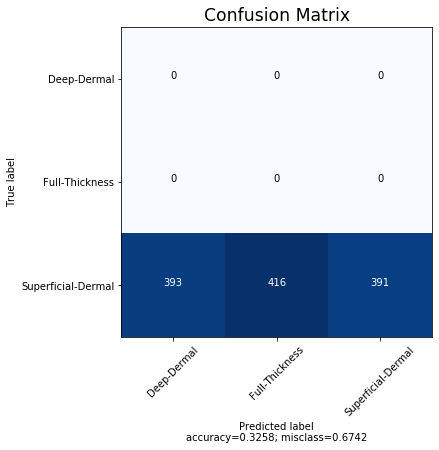

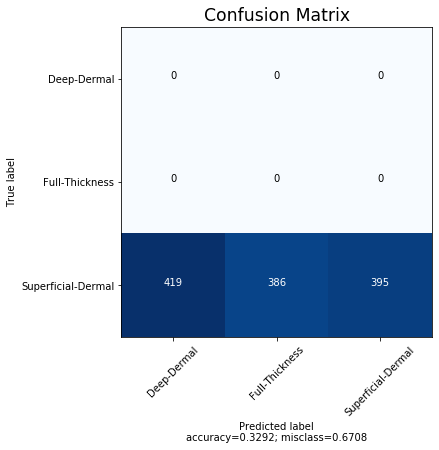

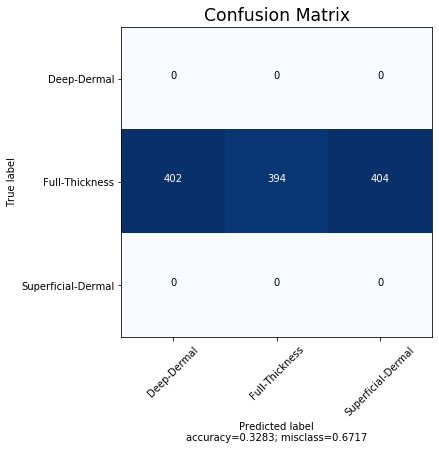

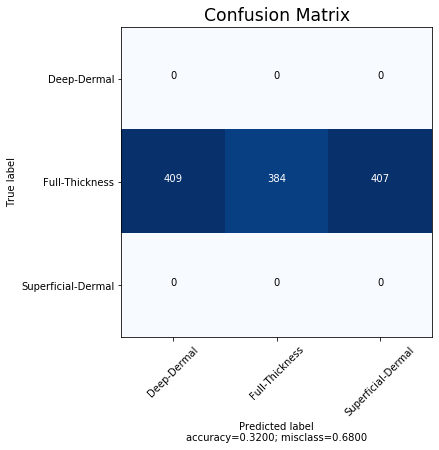

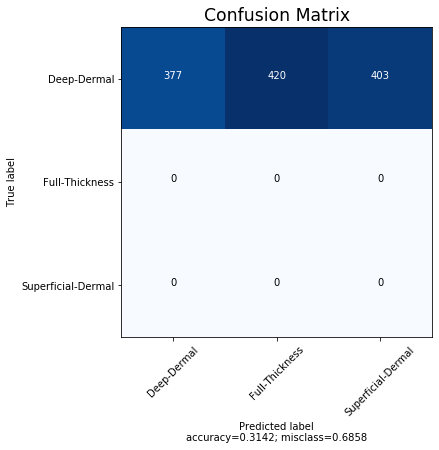

In [26]:
import numpy as np

def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize = 'xx-large')

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()
for i in range(5):
    plot_confusion_matrix(conf_matrix_list_of_arrays[i], 
                      normalize = False,
                      target_names = ['Deep-Dermal', 'Full-Thickness', 'Superficial-Dermal'],
                      title        = "Confusion Matrix")